In [7]:
import numpy as np
from scipy import stats
from scipy.integrate import quad
from ParallelSolve import solveNewsVendorSAA, majority_vote
import matplotlib.pyplot as plt
import time

solve the standard newvendor model, where the objective is max E[profit] = E[price * min(quantity, demand) - cost *  quantity]

the optimal quantity is CDF^-1 [ (price - cost) / price ]

In [8]:
def genParetoDemand(n, rng, paretoShape):
    return stats.lomax.rvs(paretoShape, size=n, random_state=rng)

def paretoOptima(price, cost, paretoShape):
    # directly solve the newvendor
    q = (price - cost) / price
    opt = stats.lomax.ppf(q, paretoShape)
    return np.ceil(opt) # take ceiling of the optimal order quantity

def paretoObj(x, paretoShape, price, cost):
    # computes the objective function for the newvendor
    def func(z):
        # density of pareto distribution
        return z * paretoShape / (1 + z) ** (paretoShape + 1)
    integral = quad(func, 0, x)[0]
    return price * (integral + x * (1 - stats.lomax.cdf(x, paretoShape))) - cost * x

In [9]:
# functions that implements the comparison between SAA and Bagging-SAA, as well as evaluating the results
def comparison_final(B_list,k_list,number_of_iterations,sample_number,rng, sample_args, *prob_args):
    # a unified function that compare SAA with different configurations of Bagging
    # prob_args: price, cost
    # sample_args: paretoShapes
    SAA_list = []
    bagging_list = [[ [] for _ in range(len(k_list)) ] for _ in range(len(B_list))] 
    for n in sample_number:
        SAA_intermediate = []
        bagging_intermediate = [[ [] for _ in range(len(k_list)) ] for _ in range(len(B_list))]
        for _ in range(number_of_iterations):
            tic = time.time()
            sample_n = genParetoDemand(n, rng, sample_args['params'])
            SAA, _ = majority_vote(sample_n, 1, n, solveNewsVendorSAA, rng, *prob_args)
            SAA_intermediate.append(SAA)
            print(f"Sample size {n}, iteration {_}, SAA time: {time.time()-tic}")

            for ind1, B in enumerate(B_list):
                for ind2, k in enumerate(k_list):
                    tic = time.time()
                    if k < 1:
                        bagging, _ = majority_vote(sample_n, B, int(n*k), solveNewsVendorSAA, rng, *prob_args)
                    else:
                        bagging, _ = majority_vote(sample_n, B, k, solveNewsVendorSAA, rng, *prob_args)
                    bagging_intermediate[ind1][ind2].append(bagging)
                    print(f"Sample size {n}, iteration {_}, B={B}, k={k}, Bagging time: {time.time()-tic}")
            
        SAA_list.append(SAA_intermediate)
        for ind1 in range(len(B_list)):
            for ind2 in range(len(k_list)):
                bagging_list[ind1][ind2].append(bagging_intermediate[ind1][ind2])
    
    return SAA_list, bagging_list

        
def evaluation_final(SAA_list, bagging_list, sample_args, *prob_args):
    sample_number_len = len(SAA_list)
    number_of_iterations = len(SAA_list[0])
    B_list_len, k_list_len = len(bagging_list), len(bagging_list[0])
    all_solutions = set()
    for i in range(sample_number_len):
        for j in range(number_of_iterations):
            all_solutions.add(SAA_list[i][j])
            for ind1 in range(B_list_len):
                for ind2 in range(k_list_len):
                    all_solutions.add(bagging_list[ind1][ind2][i][j])
    
    solution_obj_values = {str(solution): 0 for solution in all_solutions}

    for solution in all_solutions:
        obj_value = paretoObj(solution, sample_args['params'], *prob_args)
        solution_obj_values[str(solution)] = obj_value
    
    SAA_obj_list, SAA_obj_avg = [], []
    bagging_obj_list, bagging_obj_avg = [[ [] for _ in range(k_list_len) ] for _ in range(B_list_len)], [[ [] for _ in range(k_list_len) ] for _ in range(B_list_len)]
    for i in range(sample_number_len):
        current_SAA_obj_list = []
        for j in range(number_of_iterations):
            SAA_obj = solution_obj_values[str(SAA_list[i][j])]
            current_SAA_obj_list.append(SAA_obj)
        SAA_obj_list.append(current_SAA_obj_list)
        SAA_obj_avg.append(np.mean(current_SAA_obj_list))

    for ind1 in range(B_list_len):
        for ind2 in range(k_list_len):
            for i in range(sample_number_len):
                current_bagging_obj_list = []
                for j in range(number_of_iterations):
                    bagging_obj = solution_obj_values[str(bagging_list[ind1][ind2][i][j])]
                    current_bagging_obj_list.append(bagging_obj)
                bagging_obj_list[ind1][ind2].append(current_bagging_obj_list)
                bagging_obj_avg[ind1][ind2].append(np.mean(current_bagging_obj_list))
    
    return SAA_obj_list, SAA_obj_avg, bagging_obj_list, bagging_obj_avg

        
def plot_final(SAA_obj_avg, bagging_obj_avg, sample_number, B_list, k_list):
    _, ax = plt.subplots()
    ax.plot(sample_number, SAA_obj_avg, marker = 'o', markeredgecolor = 'none', color = 'blue',linestyle = 'solid', linewidth = 2, label = 'SAA')
    for ind1, B in enumerate(B_list):
        for ind2, k in enumerate(k_list):
            if B == "X" or k == "X":
                continue
            ax.plot(sample_number, bagging_obj_avg[ind1][ind2], marker = 's', markeredgecolor = 'none', linestyle = 'solid', linewidth = 2, label = f'B={B_list[ind1]}, k={k_list[ind2]}')
    ax.set_xlabel('Number of samples', size = 20)
    ax.set_ylabel('Objective', size = 20)
    ax.legend()
    fig_name  = "obj_avg_" + str(B_list) + '_' +str(k_list) + ".png"
    plt.savefig(fig_name)
    plt.show()
    return

def plot_CI_final(SAA_obj_list, bagging_obj_list, sample_number, B_list, k_list):
    number_of_iterations = len(SAA_obj_list[0])
    _, ax = plt.subplots()
    for ind1, B in enumerate(B_list):
        for ind2, k in enumerate(k_list):
            if B == "X" or k == "X":
                continue
            diff_Bk = []
            for i in range(len(sample_number)):
                diff_Bk.append([bagging_obj_list[ind1][ind2][i][j] - SAA_obj_list[i][j] for j in range(number_of_iterations)])
            
            diff_Bk_mean = np.mean(diff_Bk, axis = 1)
            diff_Bk_std_err = stats.sem(diff_Bk, axis = 1)
            diff_conf_int = 1.96 * diff_Bk_std_err

            ax.plot(sample_number, diff_Bk_mean, marker = 's', markeredgecolor = 'none', linestyle = 'solid', linewidth = 2, label = f'B={B}, k={k}')
            ax.fill_between(sample_number, diff_Bk_mean - diff_conf_int, diff_Bk_mean + diff_conf_int, alpha = 0.2)
    
    ax.axhline(0, color='grey', linewidth=2, linestyle='--') 
    ax.set_xlabel('Number of samples', size = 20)
    ax.set_ylabel('Objective difference', size = 20)
    ax.legend()
    fig_name  = "obj_CI_" + str(B_list) + '_' + str(k_list) + ".png"
    plt.savefig(fig_name)
    plt.show()
    return

In [10]:
rng = np.random.default_rng(seed=2024)

sample_args = {
    "type": "pareto",
    "params": 1.01
}

cost = 0.05
price = cost + np.random.uniform(0.5, 5)
B_list = [200,400]
k_list = [0.1, 50]
number_of_iterations = 5
sample_number = np.array([2**i for i in range(6, 13)])


Sample size 32, iteration 0, SAA time: 0.1896820068359375
Sample size 32, iteration 0, B=3, k=0.1, Bagging time: 0.34209203720092773
Sample size 32, iteration 0, B=3, k=20, Bagging time: 0.34151172637939453
Sample size 32, iteration 0, B=4, k=0.1, Bagging time: 0.3867669105529785
Sample size 32, iteration 0, B=4, k=20, Bagging time: 0.3662757873535156
Sample size 32, iteration 1, SAA time: 0.11322808265686035
Sample size 32, iteration 1, B=3, k=0.1, Bagging time: 0.3175048828125
Sample size 32, iteration 1, B=3, k=20, Bagging time: 0.30796170234680176
Sample size 32, iteration 1, B=4, k=0.1, Bagging time: 0.373737096786499
Sample size 32, iteration 1, B=4, k=20, Bagging time: 0.3697371482849121
Sample size 32, iteration 2, SAA time: 0.13492202758789062
Sample size 32, iteration 2, B=3, k=0.1, Bagging time: 0.31563305854797363
Sample size 32, iteration 2, B=3, k=20, Bagging time: 0.3344550132751465
Sample size 32, iteration 2, B=4, k=0.1, Bagging time: 0.384735107421875
Sample size 32, 

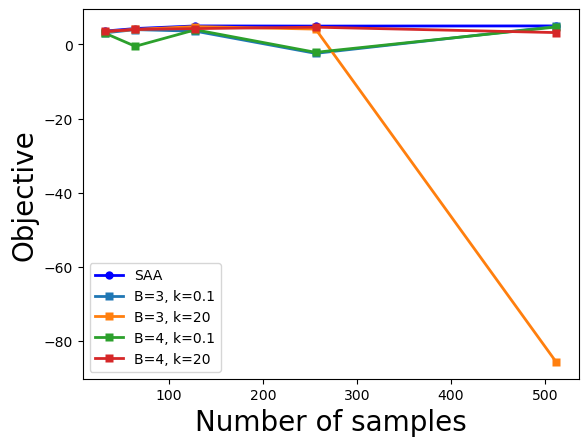

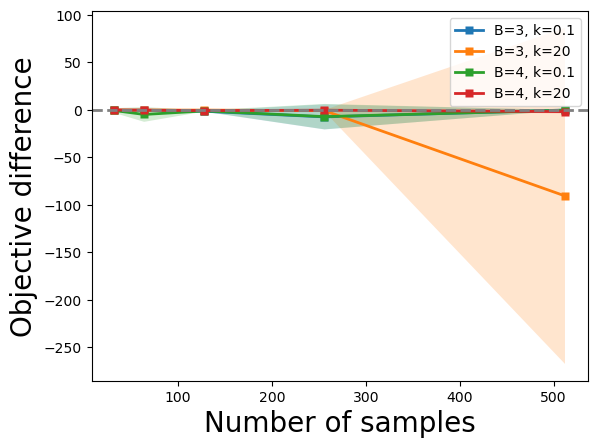

In [11]:
SAA_list, bagging_list = comparison_final(B_list, k_list, number_of_iterations, sample_number, rng, sample_args, price, cost)
SAA_obj_list, SAA_obj_avg, bagging_obj_list, bagging_obj_avg = evaluation_final(SAA_list, bagging_list, sample_args, price, cost)
plot_final(SAA_obj_avg, bagging_obj_avg, sample_number, B_list, k_list)
plot_CI_final(SAA_obj_list, bagging_obj_list, sample_number, B_list, k_list)

In [13]:
def find_parameters(B_list, k_list, number_of_iterations,sample_number, rng):
    # currently only supports len(B_list) = 1 and len(k_list) = 2
    parameters= []
    results_SAA = []
    results_bagging = []
    for iter in range(2):
        
        cost = float(np.random.uniform(0.01, 0.1))
        price = float(cost + np.random.uniform(0.5, 5))
        params = float(np.random.uniform(1.0001, 1.1))
        
        sample_args = {
            'type': 'pareto',
            'params': params
        }

        tic = time.time()
        
        SAA_list, bagging_list = comparison_final(B_list, k_list, number_of_iterations, sample_number, rng, sample_args, price, cost)
        _, SAA_obj_avg, _, bagging_obj_avg = evaluation_final(SAA_list, bagging_list, sample_args, price, cost)
        
        print(f"Iteration {iter}, time: {time.time()-tic}")

        if all(x >= y for x, y in zip(SAA_obj_avg, bagging_obj_avg[0][0])) and all(x >= y for x, y in zip(SAA_obj_avg, bagging_obj_avg[0][1])):
            continue
        else:
            name = [iter, [price, cost], params]
            plot_params(SAA_obj_avg, bagging_obj_avg, sample_number, B_list, k_list, name)
            parameters.append([price, cost, sample_args])
            results_SAA.append(SAA_obj_avg)
            results_bagging.append(bagging_obj_avg[0])
        
    return parameters, results_SAA, results_bagging

def plot_params(SAA_obj_avg, bagging_obj_avg, sample_number, B_list, k_list, name):
    _, ax = plt.subplots()
    ax.plot(sample_number, SAA_obj_avg, marker = 'o', markeredgecolor = 'none', color = 'blue',linestyle = 'solid', linewidth = 2, label = 'SAA')
    for ind1, B in enumerate(B_list):
        for ind2, k in enumerate(k_list):
            if B == "X" or k == "X":
                continue
            ax.plot(sample_number, bagging_obj_avg[ind1][ind2], marker = 's', markeredgecolor = 'none', linestyle = 'solid', linewidth = 2, label = f'B={B_list[ind1]}, k={k_list[ind2]}')
    ax.set_xlabel('Number of samples', size = 20)
    ax.set_ylabel('Objective', size = 20)
    ax.legend()
    fig_name  = str(name[0]) + '_' + str(name[1]) + '_' + str(name[2]) + ".png"
    plt.savefig(fig_name)
    # plt.show()
    return
        

Sample size 64, iteration 0, SAA time: 0.13318490982055664
Sample size 64, iteration 0, B=2, k=0.1, Bagging time: 0.2699010372161865
Sample size 64, iteration 0, B=2, k=50, Bagging time: 0.23447871208190918
Sample size 64, iteration 1, SAA time: 0.11594700813293457
Sample size 64, iteration 1, B=2, k=0.1, Bagging time: 0.20110011100769043
Sample size 64, iteration 1, B=2, k=50, Bagging time: 0.25452399253845215
Sample size 128, iteration 0, SAA time: 0.16916918754577637
Sample size 128, iteration 0, B=2, k=0.1, Bagging time: 0.2513301372528076
Sample size 128, iteration 0, B=2, k=50, Bagging time: 0.2712879180908203
Sample size 128, iteration 1, SAA time: 0.1198110580444336
Sample size 128, iteration 1, B=2, k=0.1, Bagging time: 0.2883620262145996
Sample size 128, iteration 1, B=2, k=50, Bagging time: 0.3198058605194092
Sample size 256, iteration 0, SAA time: 0.13774728775024414
Sample size 256, iteration 0, B=2, k=0.1, Bagging time: 0.20459699630737305
Sample size 256, iteration 0, B=

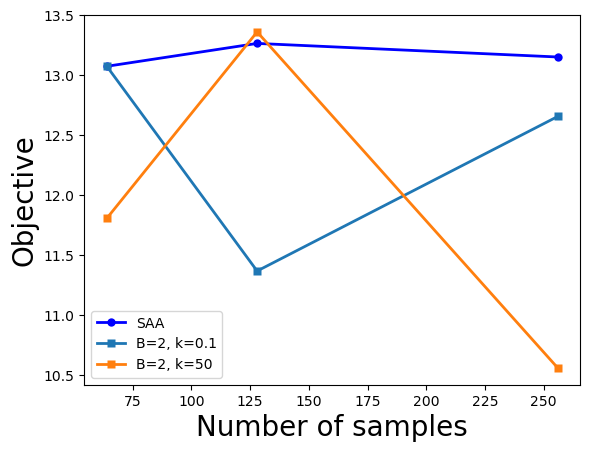

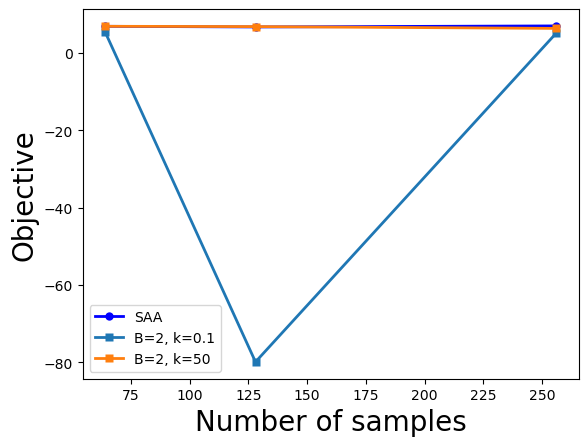

In [15]:
rng = np.random.default_rng(seed=2024)
B_list = [2]
k_list = [0.1, 50]
number_of_iterations = 2
sample_number = np.array([2**i for i in range(6, 9)])

parameters, results_SAA, results_bagging = find_parameters(B_list, k_list, number_of_iterations, sample_number, rng)

In [11]:
B = 100
number_of_iterations = 5
ratio = 0.4
sample_number = np.array([2**i for i in range(6, 14)])
large_number_sample = 200000

results_list = []
for _ in range(50):
    print(f"Experiment {_}")
    tic = time.time()

    cost = np.random.uniform(0.01, 0.05)
    price = cost + np.random.uniform(0.5, 5)
    paretoShape = np.random.uniform(1.0001, 1.001)
    
    SAA_list, majority_list = comparison(price, cost, paretoShape ,B,number_of_iterations,ratio,sample_number, rng)
    SAA_obj_lists, majority_obj_lists, SAA_obj_list, majority_obj_list = evaluation_CI(SAA_list, majority_list, price, cost, paretoShape, number_of_iterations, sample_number, large_number_sample, rng)
    result_dict = {
        'price': price,
        'cost': cost,
        'paretoShape': paretoShape,
        'SAA_obj_lists': SAA_obj_lists,
        'majority_obj_lists': majority_obj_lists,
        'SAA_obj_list': SAA_obj_list,
        'majority_obj_list': majority_obj_list
    }
    results_list.append(result_dict)
    toc = time.time()
    print(f"Experiment {_} completed in {toc - tic} seconds.")

Experiment 0


Experiment 0 completed in 32.21287989616394 seconds.
Experiment 1
Experiment 1 completed in 32.198622941970825 seconds.
Experiment 2
Experiment 2 completed in 32.685120582580566 seconds.
Experiment 3
Experiment 3 completed in 33.06950092315674 seconds.
Experiment 4
Experiment 4 completed in 33.79791808128357 seconds.
Experiment 5
Experiment 5 completed in 32.083763122558594 seconds.
Experiment 6
Experiment 6 completed in 33.159050941467285 seconds.
Experiment 7
Experiment 7 completed in 34.23758578300476 seconds.
Experiment 8
Experiment 8 completed in 33.445741176605225 seconds.
Experiment 9
Experiment 9 completed in 34.23487305641174 seconds.
Experiment 10
Experiment 10 completed in 31.77182173728943 seconds.
Experiment 11
Experiment 11 completed in 33.53093075752258 seconds.
Experiment 12
Experiment 12 completed in 32.19420003890991 seconds.
Experiment 13
Experiment 13 completed in 33.38562297821045 seconds.
Experiment 14
Experiment 14 completed in 32.35331726074219 seconds.
Experime

In [ ]:
# price: 4.523777310894456, cost: 0.04528184053304114, paretoShape: 1.0041538258131688
# price: 3.3845191372646353, cost: 0.038557124326539405, paretoShape: 1.0015234581721164
# price: 3.248440058155072, cost: 0.03308312554580492, paretoShape: 1.001586223802147

# price: 2.285013017968233, cost: 0.030215538853048445, paretoShape: 1.0002249862507948


price: 3.164218378313845, cost: 0.04122953819769612, paretoShape: 1.000647197946085


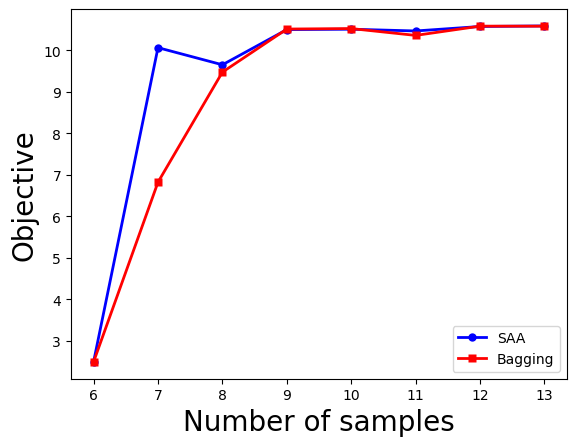




price: 4.86142342864788, cost: 0.027044012190466336, paretoShape: 1.0004720652128374


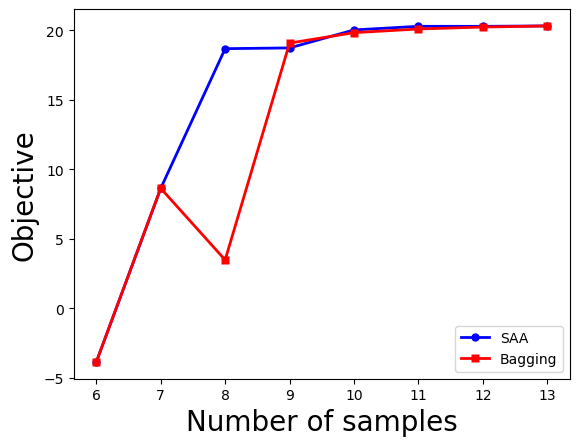




price: 2.285013017968233, cost: 0.030215538853048445, paretoShape: 1.0002249862507948


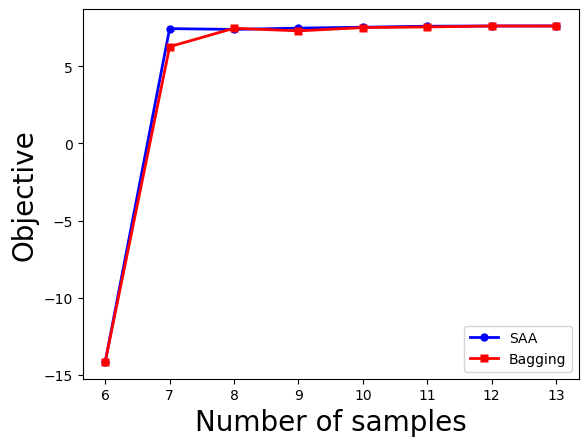




price: 1.5193043399260635, cost: 0.01892897614681987, paretoShape: 1.000183605288938


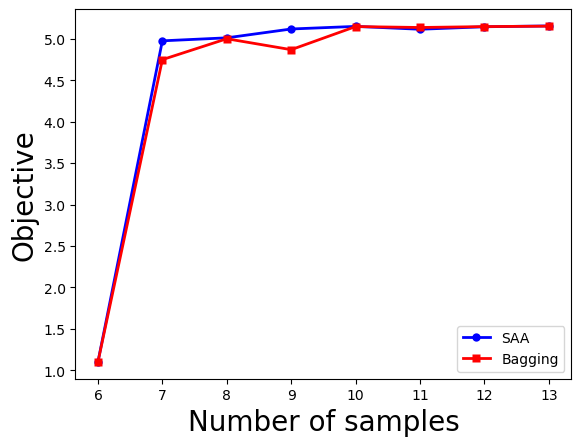




price: 3.5197767415685064, cost: 0.03998360108494674, paretoShape: 1.0007108825490987


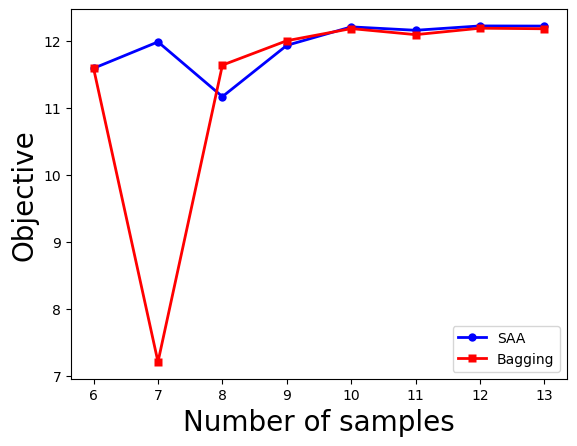




price: 4.638314402566792, cost: 0.03940585083053279, paretoShape: 1.0007072444233878


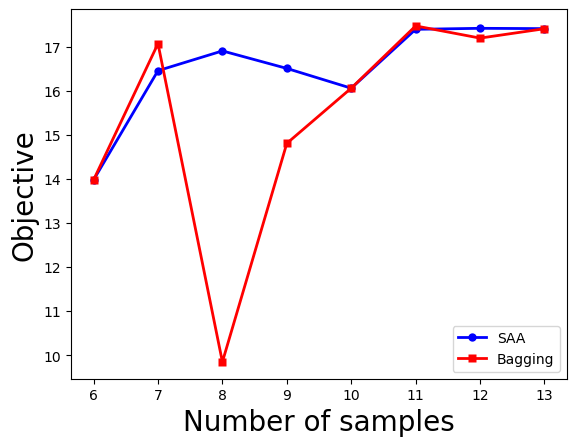




price: 1.4819931299723013, cost: 0.04696699740618643, paretoShape: 1.0003913555211195


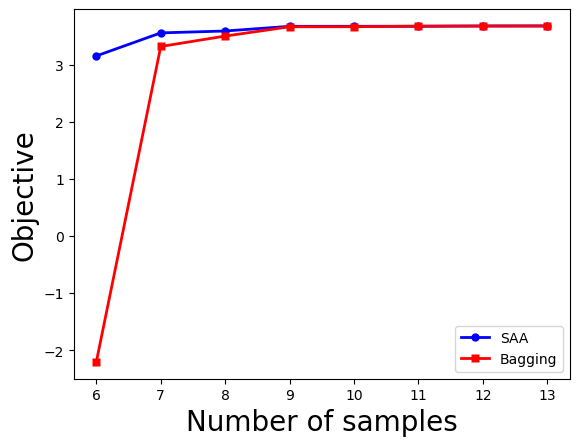




price: 3.1564090982171105, cost: 0.018339955929951104, paretoShape: 1.0004802597258522


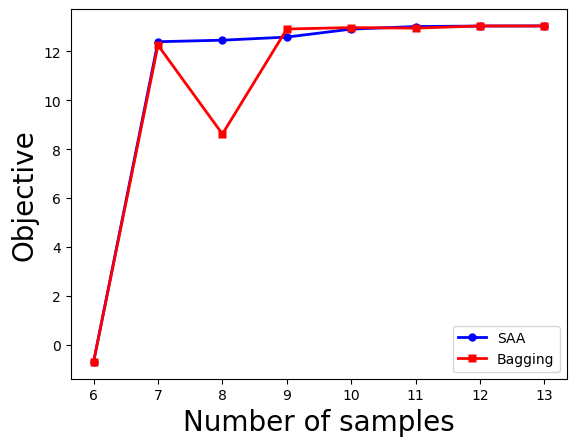




price: 2.326873456542138, cost: 0.020823905092912653, paretoShape: 1.0007350511219102


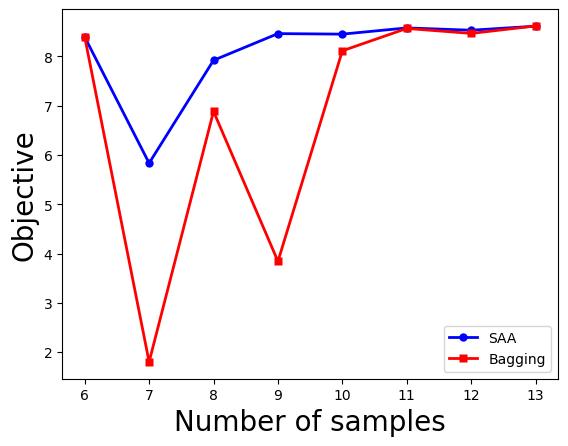




price: 3.784184154381738, cost: 0.028758800535107452, paretoShape: 1.0001104617547723


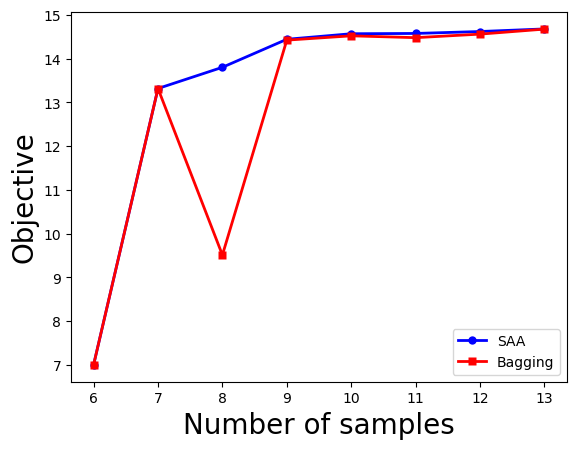




price: 4.527989403694573, cost: 0.019339486357206063, paretoShape: 1.0006176276818521


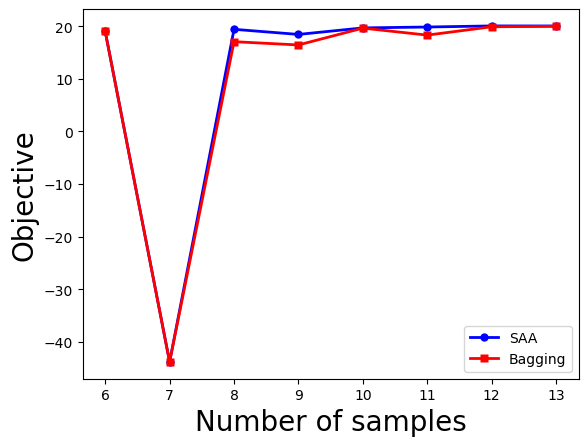




price: 0.6837805322409878, cost: 0.012467720408563254, paretoShape: 1.0004533547025758


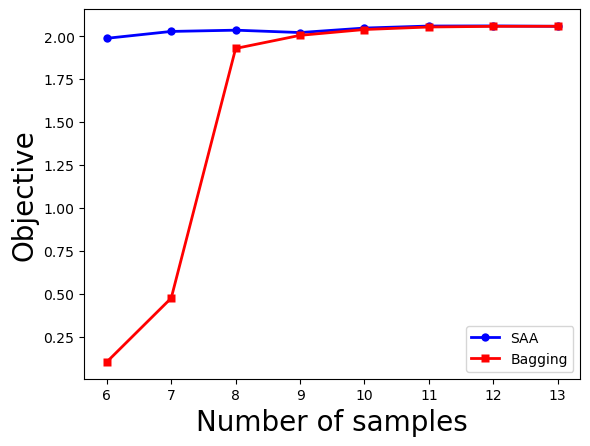




price: 2.0628593121737984, cost: 0.04510808663220987, paretoShape: 1.0007339624175957


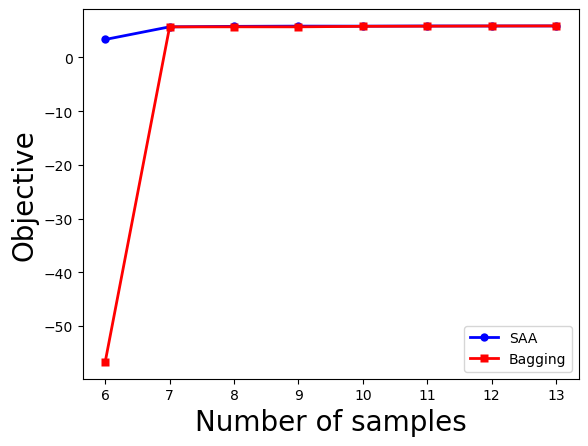




price: 3.354883127168483, cost: 0.028291931866678534, paretoShape: 1.0001296136745743


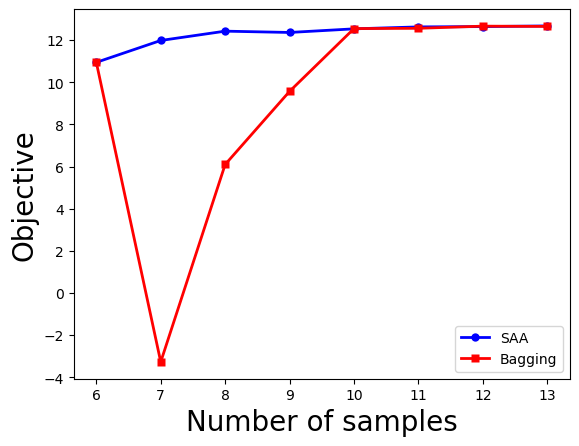




price: 5.012926567426497, cost: 0.04059324713279465, paretoShape: 1.0009680615283019


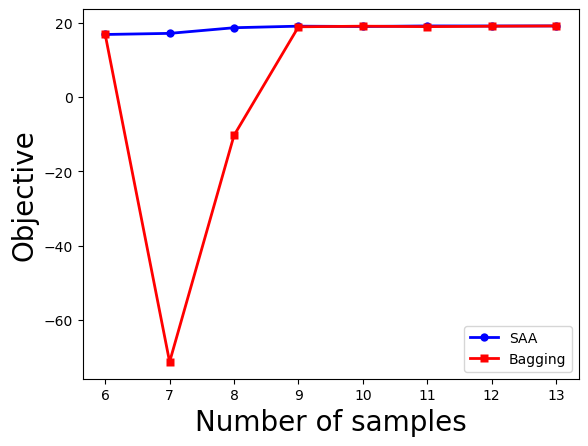




price: 3.3149603383388806, cost: 0.03808947936567622, paretoShape: 1.000137917494255


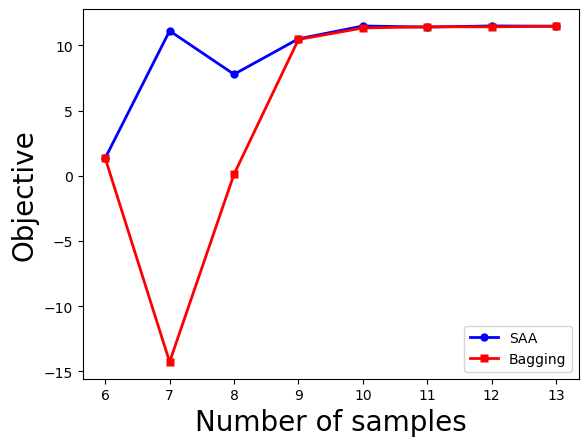




price: 0.857185753503747, cost: 0.012337535485015611, paretoShape: 1.0005600660797094


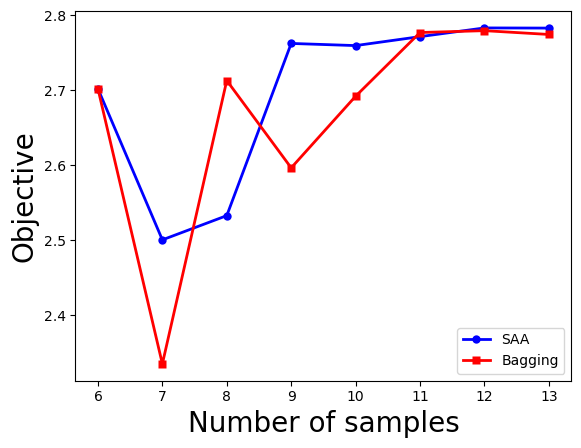




price: 4.0561486159070546, cost: 0.049912075555479565, paretoShape: 1.0005840464002527


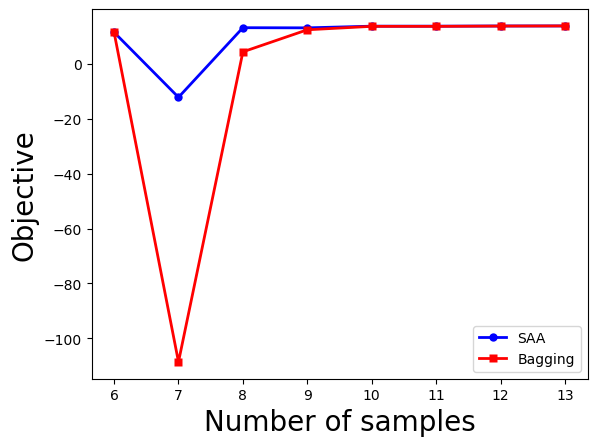




price: 0.9064694300081759, cost: 0.02739142635390523, paretoShape: 1.0007405061694237


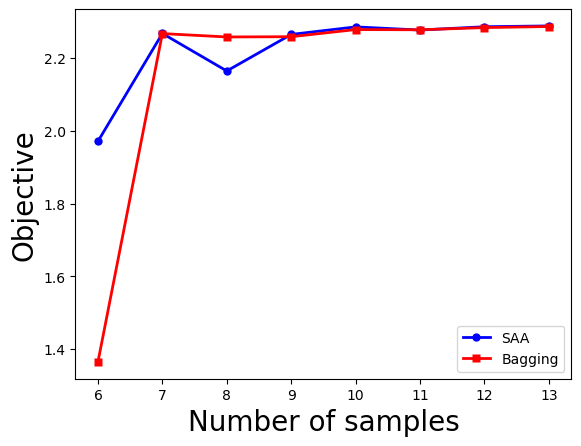




price: 2.7717214803793437, cost: 0.02567891583235954, paretoShape: 1.0002164914539873


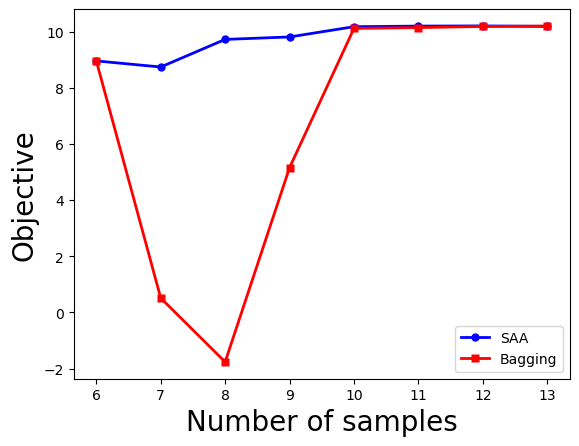




price: 3.9756213062466608, cost: 0.04138006198844895, paretoShape: 1.0003017710077298


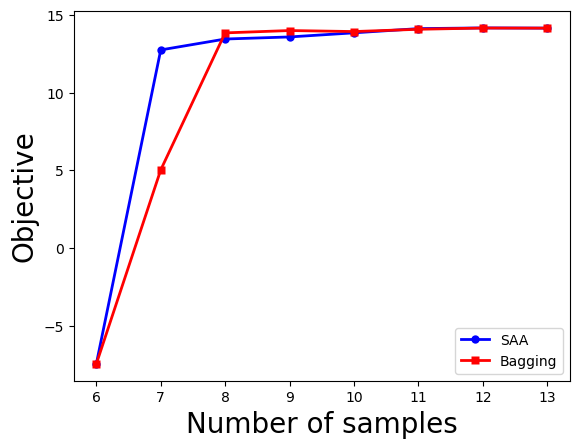




price: 4.553098253788466, cost: 0.043441312429960716, paretoShape: 1.0003750865730754


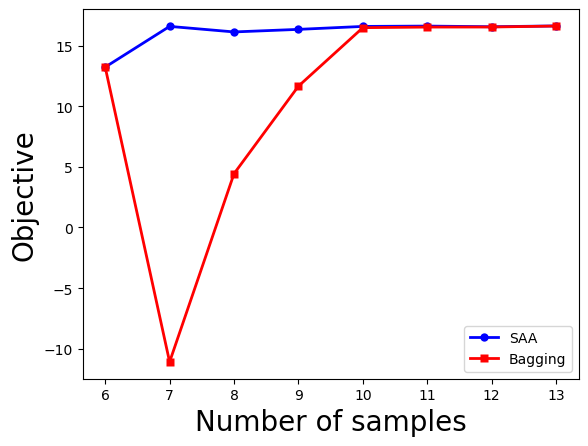




price: 0.600692757110621, cost: 0.022792933612355046, paretoShape: 1.0002473928726592


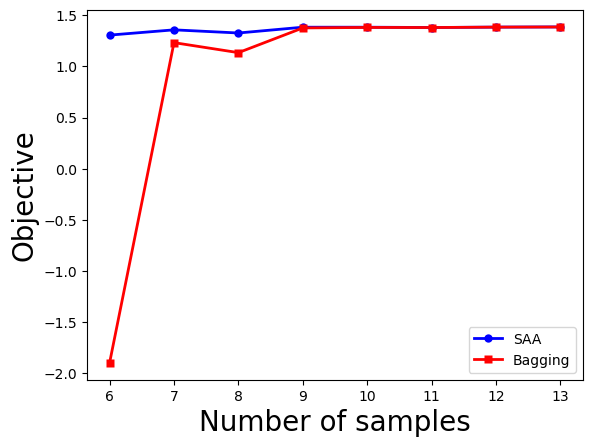




price: 1.9703871216248405, cost: 0.012844417937557293, paretoShape: 1.0002822190971776


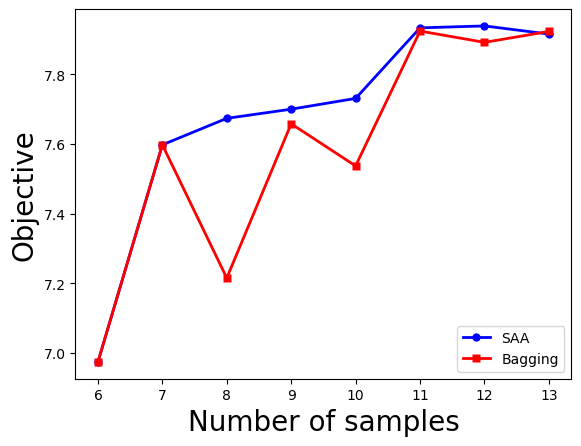




price: 1.6307960719161119, cost: 0.03989949692577722, paretoShape: 1.0004736051787406


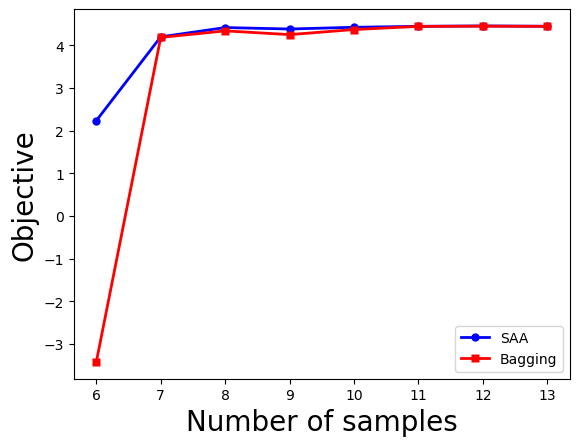




price: 2.998317111366888, cost: 0.011758691721052665, paretoShape: 1.0007370092351349


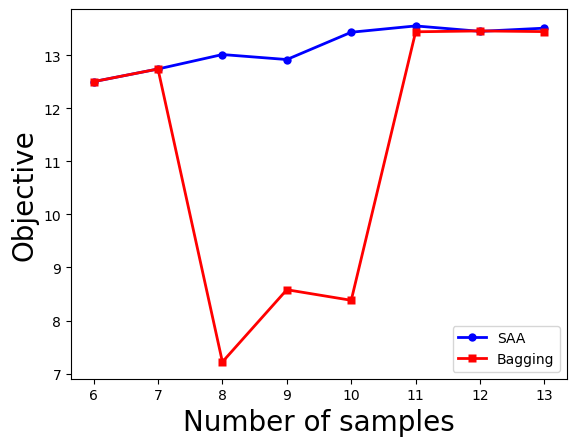




price: 2.524279568794108, cost: 0.011759880077024892, paretoShape: 1.000853906352027


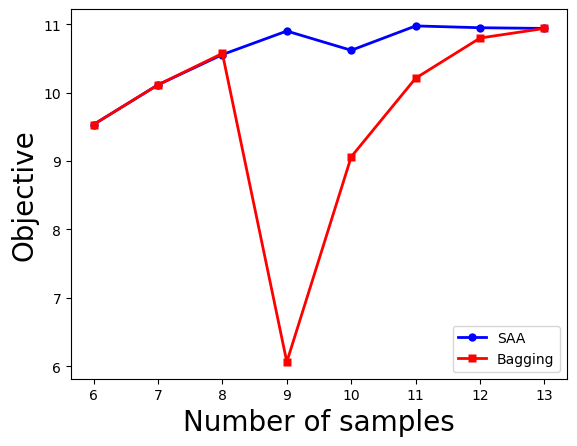




price: 5.011697304582104, cost: 0.031878431807682725, paretoShape: 1.0001138949859603


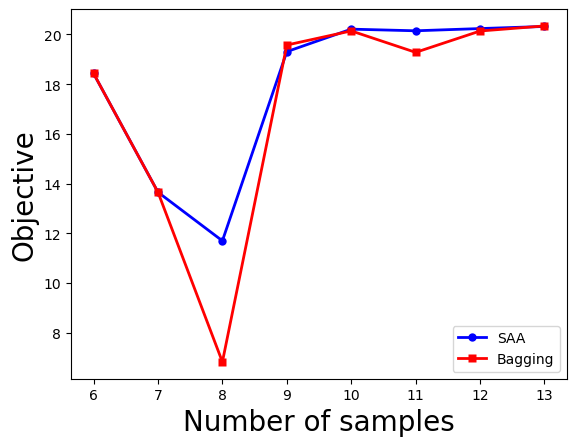




price: 1.4888967360932448, cost: 0.023783928538795754, paretoShape: 1.000636586596925


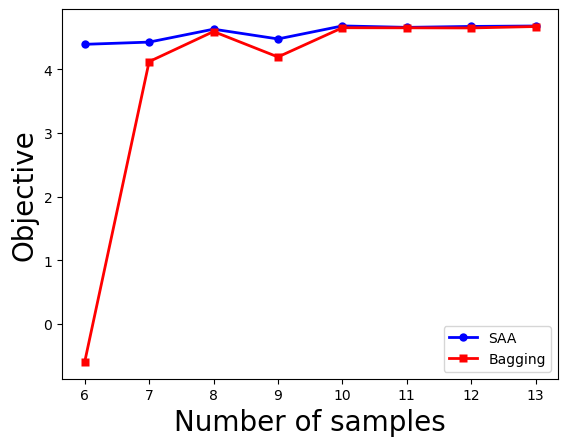




price: 4.76882572452738, cost: 0.037642012372542395, paretoShape: 1.000599474387084


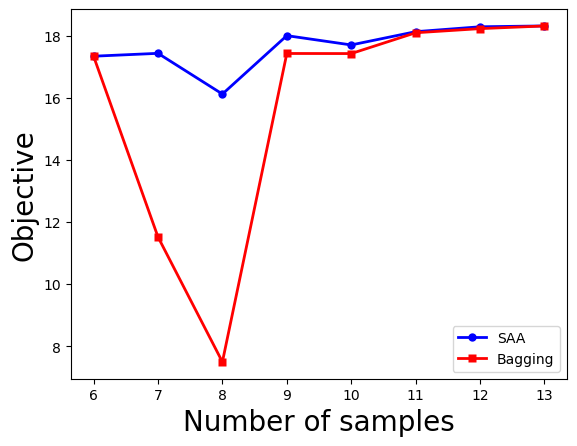




price: 4.698239800870087, cost: 0.023717302334931092, paretoShape: 1.00082755912071


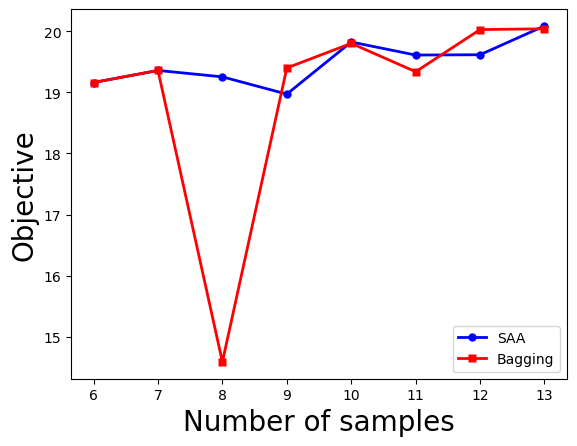




price: 2.472601368192385, cost: 0.028488220364503138, paretoShape: 1.000798423359206


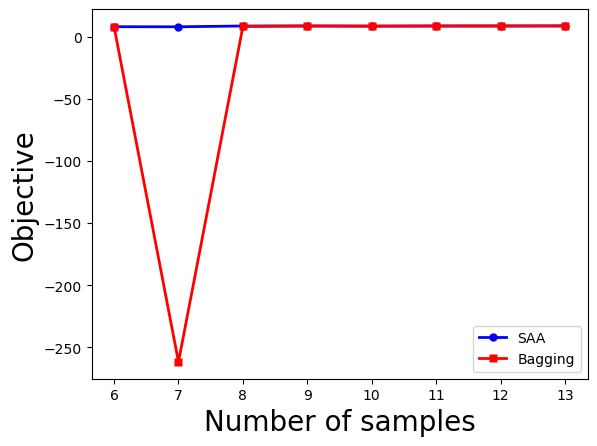




price: 1.6605203202184027, cost: 0.02870385812026737, paretoShape: 1.0002377680082504


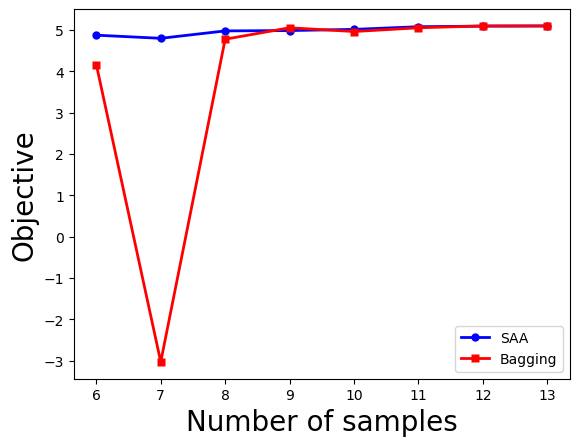




price: 4.229335195202148, cost: 0.025510121980573404, paretoShape: 1.000906496486806


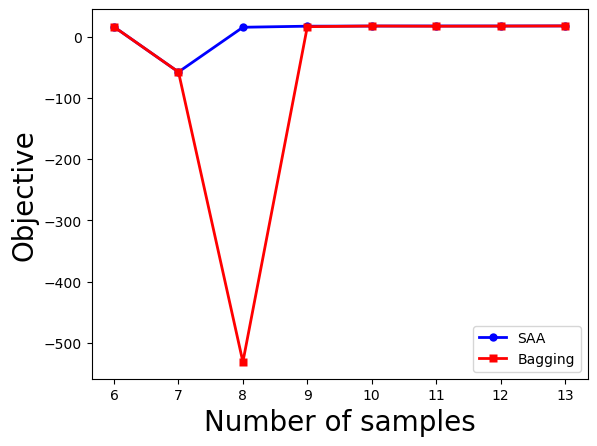




price: 3.331684193395512, cost: 0.015628421232815937, paretoShape: 1.000588198626526


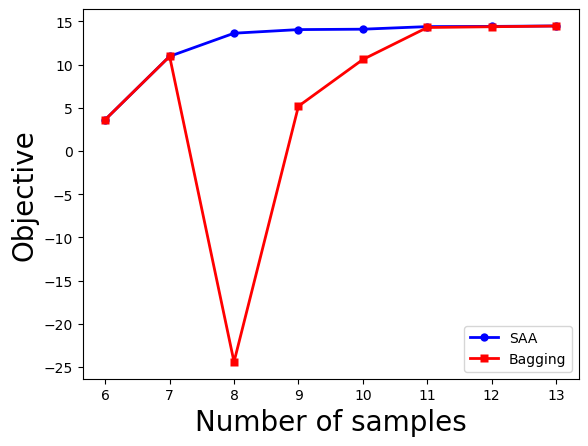




price: 5.00069247402486, cost: 0.0456066726301826, paretoShape: 1.0009477410292114


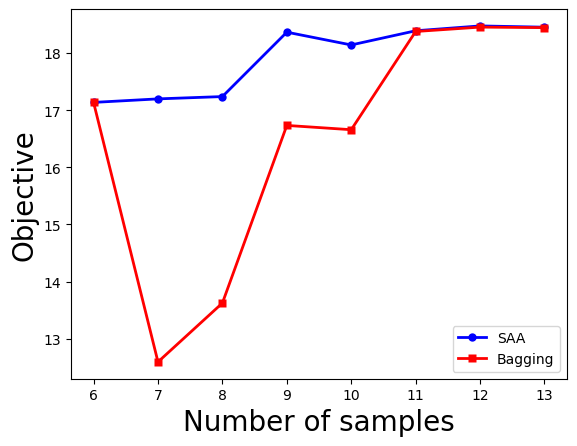




price: 4.092513304656615, cost: 0.025434377724842486, paretoShape: 1.0004547324464217


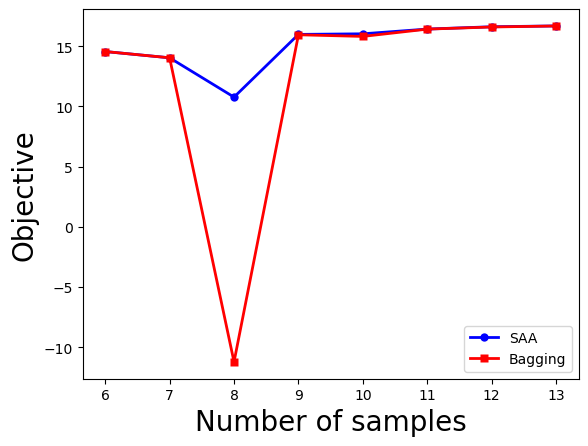




price: 1.1372278745608722, cost: 0.035217046839861314, paretoShape: 1.0001030041329846


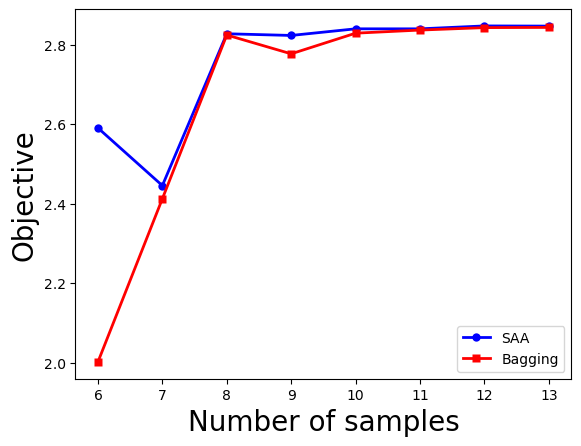




price: 3.5264245805930425, cost: 0.0359032669450467, paretoShape: 1.0004052057885726


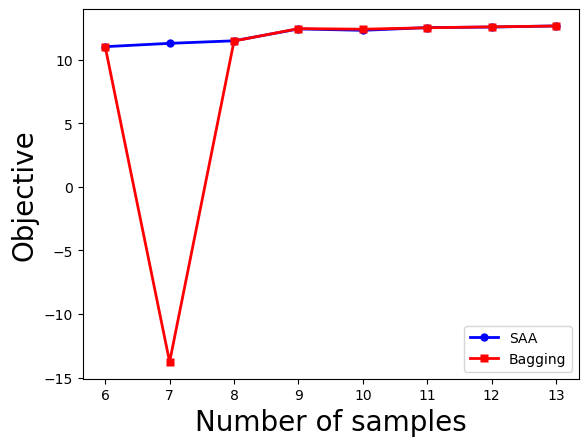




price: 2.0892409849656253, cost: 0.027224612692188198, paretoShape: 1.0004724808874317


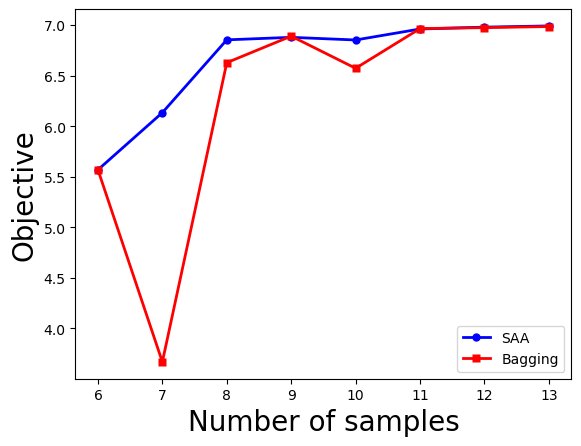




price: 2.054576698789684, cost: 0.03514704750966471, paretoShape: 1.0006138657060704


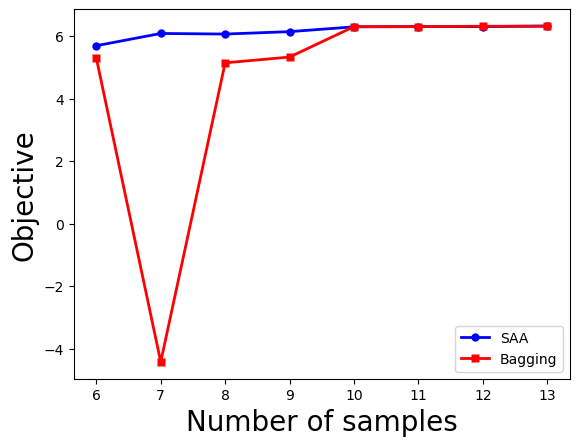




price: 2.146711715798611, cost: 0.026839697068115335, paretoShape: 1.000101848369913


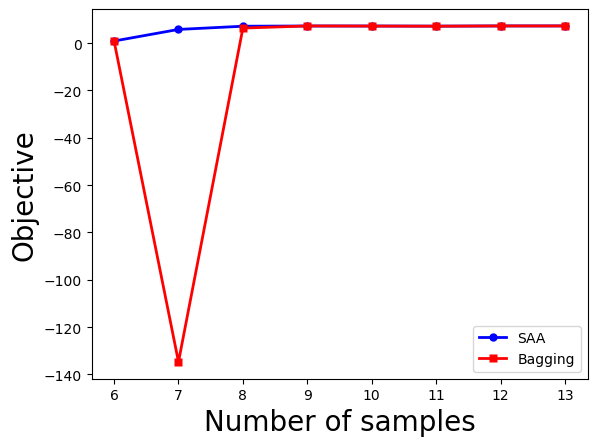




price: 2.3320664345654265, cost: 0.03626539740615921, paretoShape: 1.0005714750346633


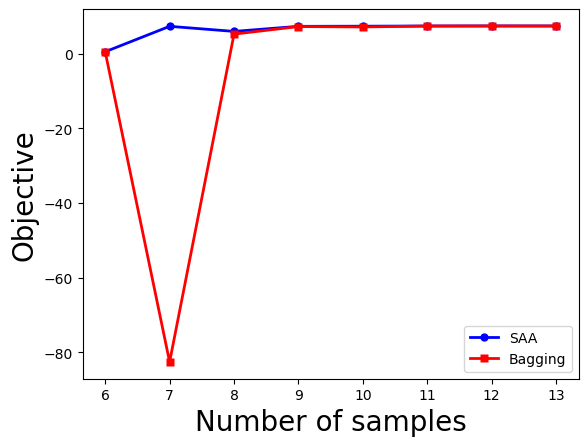




price: 3.546918504960466, cost: 0.03411800797211437, paretoShape: 1.000395434401983


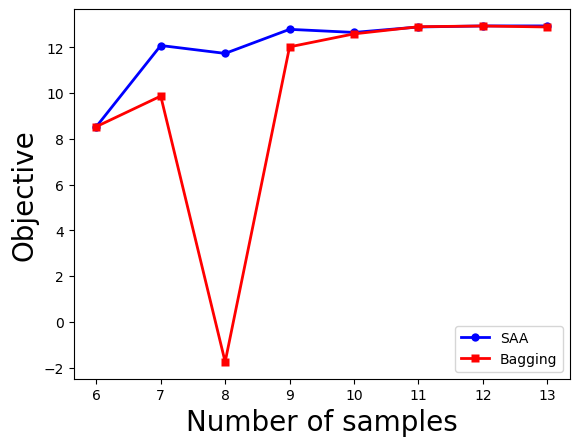




price: 1.586463635206782, cost: 0.048500733542801065, paretoShape: 1.0001106471765182


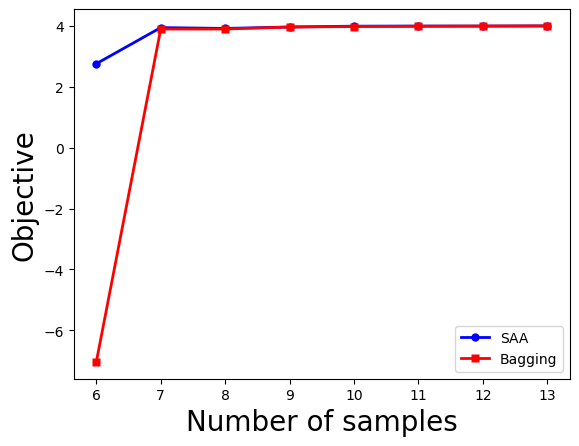




price: 1.6891848231203612, cost: 0.04946508088299275, paretoShape: 1.000150507894138


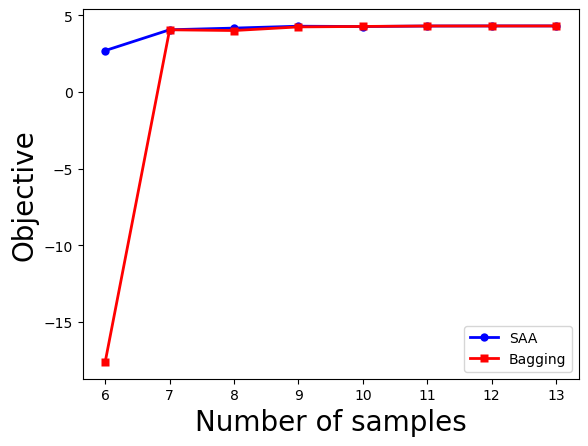




price: 1.2500952618228647, cost: 0.044638322309509426, paretoShape: 1.0001172479254519


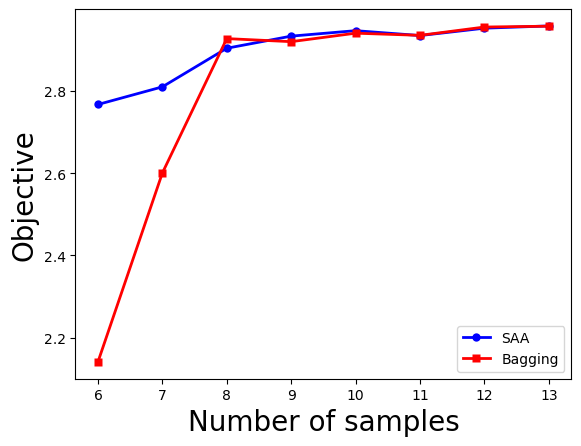




price: 2.879654134911901, cost: 0.04415068123499427, paretoShape: 1.000971849097016


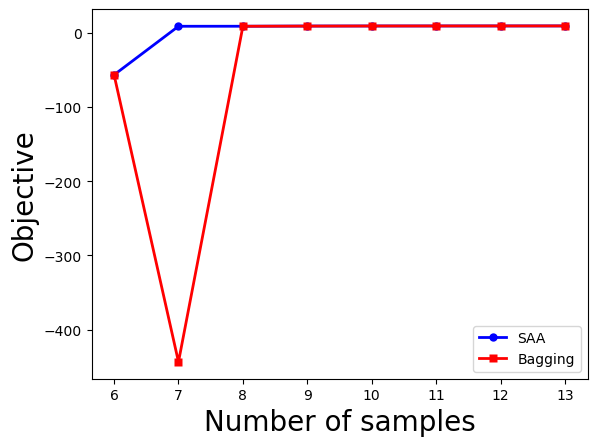




price: 3.3590894808008116, cost: 0.013989427994456426, paretoShape: 1.0005804853942857


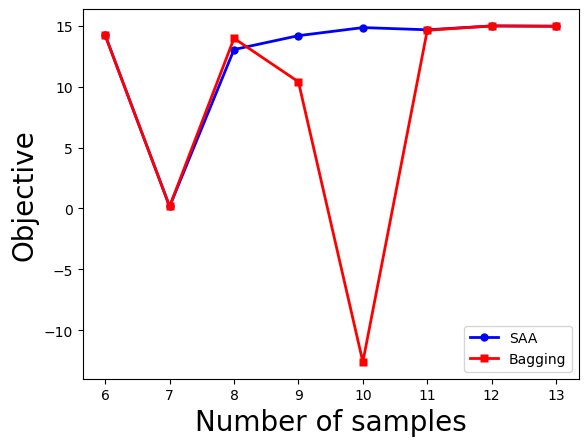




price: 1.7957986250870277, cost: 0.03460892982249801, paretoShape: 1.0009207889356615


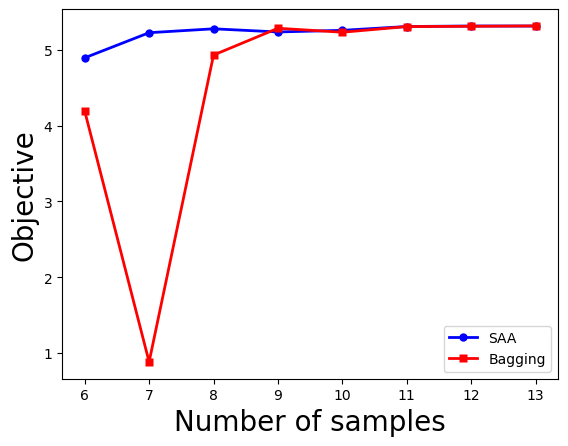

In [12]:
for result in results_list:
    print(f"price: {result['price']}, cost: {result['cost']}, paretoShape: {result['paretoShape']}")
    figure_plot(result['SAA_obj_list'], result['majority_obj_list'], [np.log2(i) for i in sample_number])
    print("\n\n")